In [165]:
import xarray as xr
import imageio
import dh_py_access.lib.datahub as datahub
from dh_py_access import package_api
import matplotlib.pyplot as plt
import datetime
import matplotlib as mpl
import ipywidgets as widgets
from IPython.display import display, clear_output
from mpl_toolkits.basemap import Basemap,shiftgrid
import numpy as np
import os
import pandas as pd
import shutil
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Avenir Lt Std'
mpl.rcParams.update({'font.size': 23})
print('matplotlib', mpl.__version__)
print ('imageio',imageio.__version__)
print ('xarray',xr.__version__)
print ('numpy',np.__version__)

matplotlib 3.0.3
imageio 2.2.0
xarray 0.10.8
numpy 1.16.4


Defining area of interest

In [161]:
latitude_north = 65; longitude_west = -38
latitude_south = 25; longitude_east = 37

In [162]:
API_key = open('APIKEY').read().strip()
current_folder = os.path.abspath('')
server = 'api.planetos.com/'

In [163]:
dataset_key = 'noaa_gfs_wafs_global'
variable_names = 'all'
area = 'Europe'

Here we define functions for making images and animation. 

In [164]:
def make_imgs(dd, lonmap,latmap, var, vmin,vmax,temp_folder,title):
    for k in range(0,len(dd[var])):
        filename = temp_folder + 'ani_' + str(k).rjust(3,'0') + '.png'
        fig = plt.figure(figsize = (14,12))
        ax = fig.add_subplot(111)
        data_k = data[k]
        if 'CAT' in var:
            data_k[data_k < 5] == np.nan
            vmin = 10; vmax = 110
        pcm = m.contourf(lonmap,latmap,data_k,levels = np.arange(vmin,vmax,1),cmap="RdYlGn_r")

        m.drawcoastlines(color='#222933')
        m.drawcountries(color='#222933')
        cbar = plt.colorbar(pcm,fraction=0.035, pad=0.03,label = var + ' [' + dd[var].units + ']')
        
        ttl = plt.title(title + '\n' + str(dd[var].time[k].data)[:-10],fontweight = 'bold')
        ttl.set_position([.5, 1.05])
        if not os.path.exists(temp_folder):
            os.mkdir(temp_folder)

        plt.savefig(filename)
        if k == 1:
            plt.show()
        plt.close()

def make_anim(folder,anim_name):
    files = sorted(os.listdir(folder))
    fileList = []
    for file in files:
        if not file.startswith('.'):
            complete_path = folder + file
            fileList.append(complete_path)
    
    writer = imageio.get_writer(anim_name, fps=2)
    
    for im in fileList:
        writer.append_data(imageio.imread(im))
    writer.close()
    print ('Animation is saved as ' + anim_name + ' under current working directory')
    shutil.rmtree(folder)

In the following cell we are downloading the data.

In [166]:
dh=datahub.datahub(server,'v1',API_key)
package = package_api.package_api(dh,dataset_key,variable_names,longitude_west,longitude_east,latitude_south,latitude_north,area_name=area+variable_names)
package.make_package()
package.download_package()

Package exists
File already downloaded


Now we open the file by using xarray.

In [167]:
dd1 = xr.open_dataset(package.local_file_name)

Select your desired variable

In [147]:
variables = [n for n in dd1.data_vars.keys() if not n.startswith('LatLon')]
droplist0 = list(variables)
selecter0 = widgets.Dropdown(
        options=droplist0,
        value=droplist0[0],
        description='Select dataset:',
        disabled=False,
        button_style='' 
    )

display(selecter0)

If there is data on different isobaric levels for chosen variable, then choose a level below.

In [168]:
chosen_var = selecter0.value
dims = dd1[chosen_var].dims
iso = [n for n in dims if n.startswith('isobaric')]
if iso:
    isobaric_heights = dd1[iso[0]].values
    droplist1 = list(isobaric_heights)
    selecter1 = widgets.Dropdown(
        options=droplist1,
        value=droplist1[0],
        description='Sel isobaric height (Pa):',
        disabled=False,
        button_style='' 
    )

    display(selecter1)

Defining some names, basemap for images, make temporary folder etc.

In [170]:
# dd1['longitude'] = ((dd1.longitude+180) % 360) - 180
if iso:
    i_iso = [i for i,n in enumerate(dd1[iso[0]].values) if n == selecter1.value][0]
    anim_name =  os.path.abspath('') + '/'+ chosen_var +'_' + str(dd1[iso[0]][i_iso].values/100)[:-2] + '_mb.mp4'
    title = dd1[chosen_var].long_name +' ' + str(dd1[iso[0]][i_iso].values/100)[:-2] + ' hPa'
    data, lon = shiftgrid(180,dd1[chosen_var][:,i_iso].values,dd1.lon.values,start=False)
else:
    anim_name =  os.path.abspath('') + '/'+ chosen_var + '_.mp4'
    data, lon = shiftgrid(180,dd1[chosen_var].values,dd1.lon.values,start=False)
    title = dd1[chosen_var].long_name

m = Basemap(projection='merc', lat_0 = 0, lon_0 =  (longitude_east + longitude_west)/2,
         resolution = 'l', area_thresh = 0.05,
         llcrnrlon=longitude_west, llcrnrlat=latitude_south,
         urcrnrlon=longitude_east, urcrnrlat=latitude_north)

lons,lats = np.meshgrid(lon,dd1.lat)
lonmap,latmap = m(lons,lats)
temp_folder = './ani/'
if not os.path.exists(temp_folder):
    os.mkdir(temp_folder)

Here we automatically choose minimal and maximum values for the graph, but feel free to choose it manually by givin vmin and vmax value. 

Then we call out function make_imgs what is define above. 

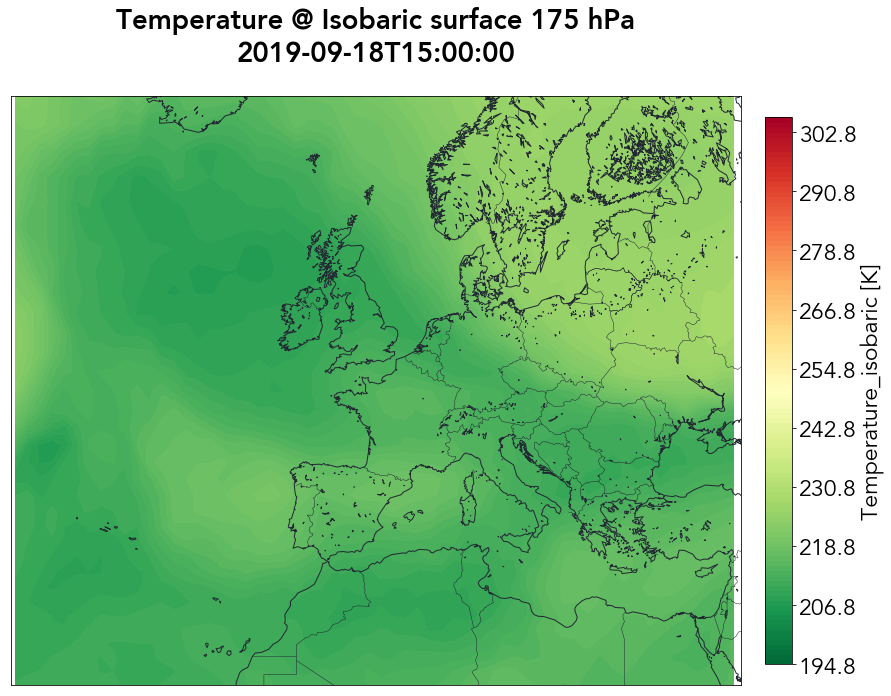

In [171]:
vmin = np.nanmin(dd1[chosen_var].values); vmax = np.nanmax(dd1[chosen_var].values)
make_imgs(dd1, lonmap, latmap, chosen_var, vmin,vmax,temp_folder, title)

This calls out function make_anim that makes animation of images that were made above. 

In [172]:
make_anim(temp_folder,anim_name)

Animation is saved as /Users/etoodu/Desktop/planetOS/git/planetos-datahub-data-curation/Access_API_demo/notebooks/Temperature_isobaric_175_mb.mp4 under current working directory


## Example on how to use Point API below

In [173]:
lon = 24.8325; lat = 59.413333
point_query = 'https://api.planetos.com/v1/datasets/noaa_gfs_wafs_global/point?lon={0}&lat={1}&apikey={2}&var=u-component_of_wind_isobaric,v-component_of_wind_isobaric&count=5000&csv=true&z=all&reftime_recent=True'.format(lon,lat,API_key)
data_csv = pd.read_csv(point_query)

In [174]:
data_csv['wind_speed'] = np.sqrt(data_csv['data:u-component_of_wind_isobaric']**2 + data_csv['data:v-component_of_wind_isobaric']**2)

Vertical wind profile plot, where we use the first time frame of the forecast. 

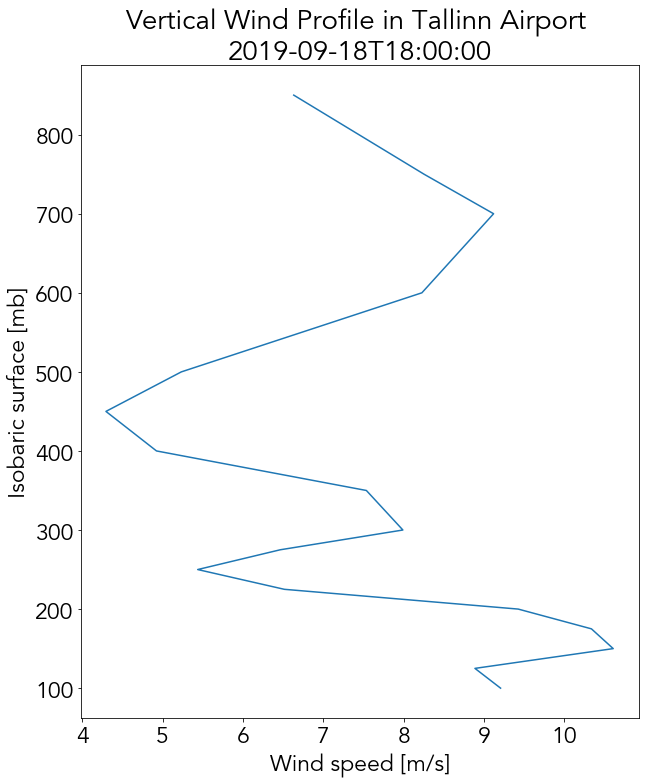

In [175]:
fig = plt.figure(figsize = (10,12))
ax = fig.add_subplot(111)
ax.plot(data_csv['wind_speed'][0:17],data_csv['axis:z'][0:17]/100)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Isobaric surface [mb]')
plt.title('Vertical Wind Profile in Tallinn Airport \n' + str(data_csv['axis:time'][0]))
plt.savefig('vertical_wind_profile_' + str(data_csv['axis:time'][0]).replace(':','') + '.png',bbox_inches='tight')
plt.show()
plt.close()

An other plot of vertical wind profile with u and v components. 

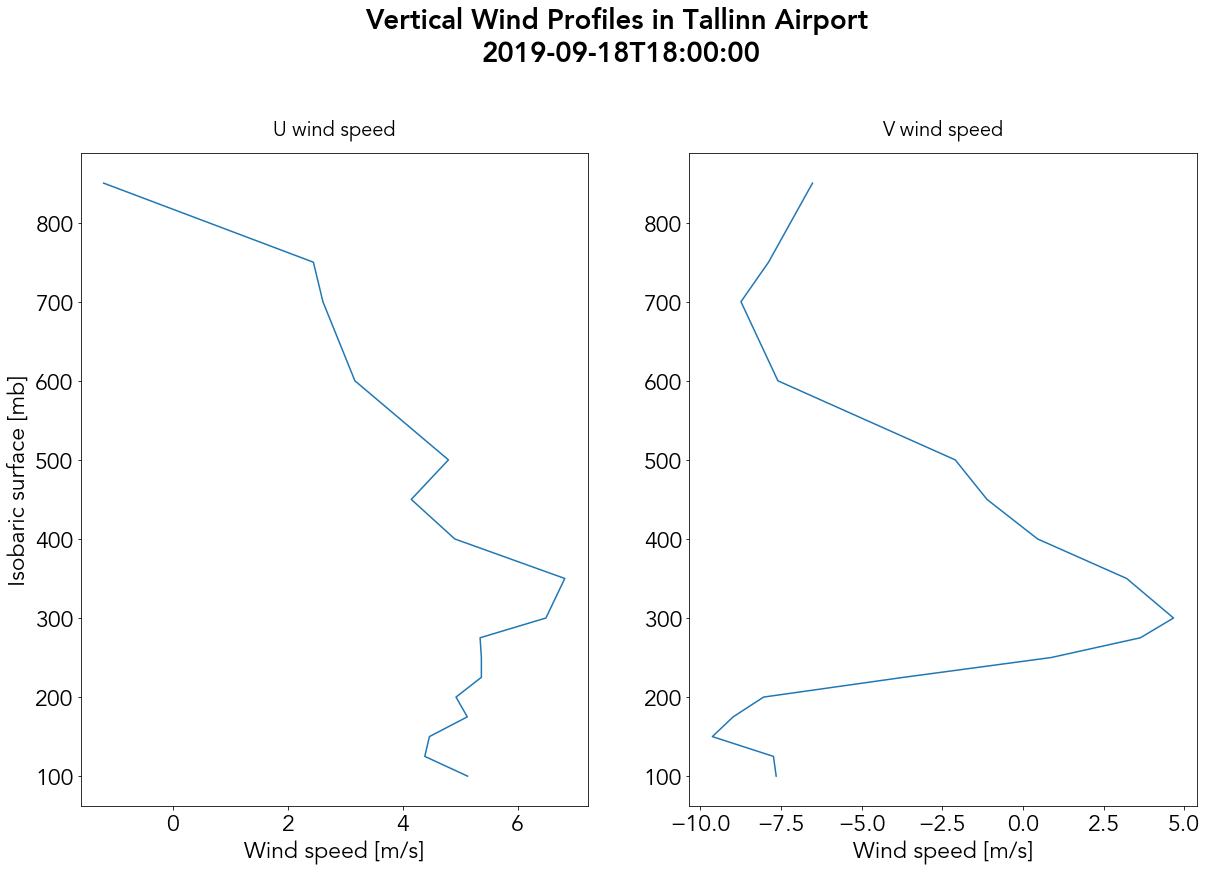

In [176]:
fig = plt.figure(figsize = (20,12))

ax1 = fig.add_subplot(121)
ax1.plot(data_csv['data:u-component_of_wind_isobaric'][0:17],data_csv['axis:z'][0:17]/100)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Isobaric surface [mb]')
ax1.set_title('U wind speed',fontsize=20, y=1.02)

ax2 = fig.add_subplot(122)
ax2.plot(data_csv['data:v-component_of_wind_isobaric'][0:17],data_csv['axis:z'][0:17]/100)
plt.xlabel('Wind speed [m/s]')
#plt.ylabel('Isobaric surface [mb]')
ax2.set_title('V wind speed',fontsize=20,y = 1.02)

ttl = fig.suptitle('Vertical Wind Profiles in Tallinn Airport \n' + str(data_csv['axis:time'][0]),fontweight = 'bold')
ttl.set_position([.5, 1.05])

plt.savefig('uv_vertical_wind_profiles_' + str(data_csv['axis:time'][0]).replace(':','') + '.png',bbox_inches='tight')
plt.show()
plt.close()